In [1]:
import os
base=os.path.dirname(os.path.realpath("__file__")).split(os.sep)
os.chdir(os.sep+os.path.join(*base[:-1]))
os.getcwd()

'/Users/haihabi/projects/NormFlowPy'

In [2]:
import numpy as np
import normflowpy as nfp
import datasets
import torch
from matplotlib import pyplot as plt
from torch.distributions import MultivariateNormal
from experiments.functions import run_training

In [3]:
dataset_type = datasets.DatasetType.MOONS
n_training_samples = 50000
n_validation_samples = 10000
n_flow_blocks = 3
batch_size = 32
n_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Working Device is set to:" + str(device))
training_data = datasets.get_dataset(dataset_type, n_training_samples)
training_dataset_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                                      shuffle=True, num_workers=0)

validation_data = datasets.get_dataset(dataset_type, n_validation_samples)
validation_dataset_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                                        shuffle=False, num_workers=0)

Current Working Device is set to:cpu


# Create Glow Normalizing Flow Model

In [4]:
dim = training_data.dim()  # get data dim
base_distribution = MultivariateNormal(torch.zeros(dim, device=device),
                                       torch.eye(dim, device=device))  # generate a class for base distribution
flows = []
for i in range(n_flow_blocks):
    flows.append(
        nfp.flows.ActNorm(dim=dim))
    flows.append(
        nfp.flows.InvertibleFullyConnected(dim=dim))
    flows.append(
        nfp.flows.AffineCoupling(x_shape=[dim], parity=i % 2, net_class=nfp.base_nets.generate_mlp_class(), nh=32))
flow = nfp.NormalizingFlowModel(base_distribution, flows).to(device)

# Set Optimizer and run training

In [5]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
run_training(n_epochs, training_dataset_loader, validation_dataset_loader, flow, optimizer, device)

Starting Training Loop


End Epoch with training loss:0.7749309667165052 and validtion loss:0.6348536557282883
End Epoch with training loss:0.5798774908463008 and validtion loss:0.536163659807973
End Epoch with training loss:0.5079237787256772 and validtion loss:0.4752305024348128
End Epoch with training loss:0.46097942178095297 and validtion loss:0.44548572147616183
End Epoch with training loss:0.42892127144207043 and validtion loss:0.41026560767009235
End Epoch with training loss:0.40179547567399587 and validtion loss:0.38587775336096464
End Epoch with training loss:0.3742619390031579 and validtion loss:0.35520271347544063
End Epoch with training loss:0.3449574706650512 and validtion loss:0.34312056800047047
End Epoch with training loss:0.31367778956832904 and validtion loss:0.2941466412795618
End Epoch with training loss:0.2826601621561987 and validtion loss:0.27287068410803333
End Epoch with training loss:0.26119281217141255 and validtion loss:0.2533848402551569
End Epoch with training loss:0.2479003755636

# Plot probability Map

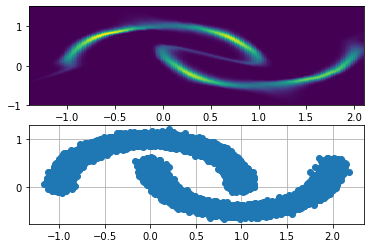

In [6]:
def generate_probability_map(n_points, in_x_min, in_x_max, in_y_min, in_y_max, in_flow_model, in_device):
    results = []
    for x_tag in torch.linspace(in_x_min, in_x_max, n_points):
        _results_y = []
        for y_tag in torch.linspace(in_y_min, in_y_max, n_points):
            d = torch.stack([x_tag, y_tag]).reshape([1, -1]).to(in_device)
            _results_y.append(in_flow_model.nll(d).item())
        results.append(_results_y)
    return np.exp(-np.asarray(results)).T


x_min = -1.4
x_max = 2.1
y_min = -1
y_max = 1.5
res = generate_probability_map(200, x_min, x_max, y_min, y_max, flow, device)

fig, (ax0, ax1) = plt.subplots(2)
x = np.linspace(x_min, x_max, 200)
y = np.linspace(y_min, y_max, 200)

xx, yy = np.meshgrid(x, y)
im = ax0.pcolormesh(xx, yy, res)

ax1.plot(training_data[:, 0], training_data[:, 1], "o")
ax1.grid()
plt.show()